[View in Colaboratory](https://colab.research.google.com/github/eveem/practice/blob/master/app_word2vec_v2.ipynb)

### Install and import packages 

In [1]:
!pip install xlrd
!pip install pandas
!pip install -U -q PyDrive
!pip install sklearn_crfsuite
!pip install gensim
!pip install networkx
!pip install pydot
!pip install cairocffi
!pip install graphviz
!pip install gprof2dot
!pip install pydot-ng

import graphviz 
import gensim
import pickle
import pydot
import xlrd
import re
import matplotlib.pyplot as plt
import matplotlib.image as mping
import networkx as nx
import pandas as pd
import zipfile, os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files
from IPython.display import Image, display

!apt-get update -y
!apt-get install python-pydot -y --allow-unauthenticated

Hit:1 http://archive.ubuntu.com/ubuntu artful InRelease
Get:2 http://security.ubuntu.com/ubuntu artful-security InRelease [83.2 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu artful-backports InRelease [74.6 kB]
Fetched 247 kB in 0s (264 kB/s)


Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pydot is already the newest version (1.0.28-2).
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


### Define function

In [0]:
w2v_model = ''
dict_sort = []
top10word = tuple()

In [0]:
def upload_xlsx ():
  uploaded = files.upload()
  for i in uploaded:
    file_name = i
    return file_name

def create_csv ():
  file_name = upload_xlsx()
  xls = pd.ExcelFile(file_name, on_demand = True)
  sheets = xls.sheet_names
  print('Sheet name list : ', end='')
  print(sheets)
  while True:
    sheet_name = input('Enter sheet name : ')
    if sheet_name in sheets:
      break
    else:
      print('Error!! Do not have this sheet name..')

  df = pd.read_excel(file_name, sheetname=sheet_name, index_col=None)
  df.to_csv('csvfile.csv', encoding='utf-8', index=False)
  print('Create CSV file complete...')
  
def create_text_list ():
  df = pd.read_csv('csvfile.csv')
  print('Field name list : ', end='')
  fields = df.columns.values
  print(fields)
  while True:
    field_name = input('Enter field name : ')
    if field_name in fields:
      break
    else:
      print('Error!! Do not have this field name..')

  text_list = [i for i in df[field_name] if i]
  print('Create list of text complete...')
  return text_list

def sent2labels(sent):
  return [label for cur, tag in sent]

def sent2features(sent):
  data = []
  for cur, tag in sent:
    data.append({'current': cur, 'tag': tag})
  return data

def generate_feature (text_list):
  tag_type = ['c', 'n', 'v', 'w', 't', 's', 'd']
  rex_thai = re.compile(r"[^\u0E00-\u0E7F' ]|^'|'$|''")
  c_tag = set('กขฃคฆงจชซญฎฏฐฑฒณดตถทธนบปพฟภมยรลวศษสฬอ')
  n_tag = set('ฅฉผฝฌหฮ')
  v_tag = {'ะ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'า', 'ำ', 'ๅ', '็', 'ั'}
  w_tag = {'เ', 'แ', 'โ', 'ใ', 'ไ'}
  t_tag = {'่',  '้', '๊', '๋'}
  s_tag = {'ฺ', '์', 'ๆ', 'ฯ'}
  d_tag = set('0123456789')
  
  new_text = []
  for line in text_list:
    char_to_remove = re.findall(rex_thai, line)
    list_with_char_removed = [char for char in line if not char in char_to_remove]
    line = ''.join(list_with_char_removed)
    temp = line
    if ' ' in line:
      temp = temp.replace(' ', '')
    new_text.append(temp)  
    
  raw_data = []
  for line in new_text:
    len_line = len(line)
    d = []
    for i in range(0, len_line):
      t = ''
      for tag in tag_type:
        if line[i] in vars()[tag + '_tag']:
          t = tag
      d.append((line[i], t))
    raw_data.append(d)
  print('Create list of char and feature complete...')
  return raw_data

def download_model ():
  # change by url
  zip_id = '1WwyyzOS7rsDGTSnxCkEBXaLqGBmGUHA4'
  
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Downloading zip file
  myzip = drive.CreateFile({'id': zip_id})
  myzip.GetContentFile('model.zip')

  # Uncompressing zip file
  zip_ref = zipfile.ZipFile('model.zip', 'r')
  zip_ref.extractall('MODEL/')
  
  with open('./MODEL/model.pickle', 'rb') as handle:
    crf_model = pickle.load(handle)

  print('Download model complete...')
  return crf_model

def tokenize (model, x_data):
  x_data = [sent2features(s) for s in x_data]
  y_data = model.predict(x_data)
  splited_list = []
  len_text = len(x_data)
  
  for i in range(0, len_text):
    len_line = len(x_data[i])
    split_by_pipe = ''
    if len_line > 1:
      for j in range(0, len_line):
        if y_data[i][j] == 'B' and j != 0:
          split_by_pipe += '|'
        split_by_pipe += x_data[i][j]['current']
      splited_list.append(split_by_pipe)
  return splited_list

def generate_word2vec (pipe_list):
  documents = []
  dict_count = dict()
  
  for i in pipe_list:
    temp = i.split('|')
    documents.append(temp)
    for word in temp:
      if word in dict_count:
        dict_count[word] += 1
      else:
        dict_count[word] = 1
  
  print('Generate list of text split by pipe complete...')
  
  model = gensim.models.Word2Vec (documents, size=150, window=10, min_count=2, workers=10)
  model.train(documents, total_examples=len(documents), epochs=10)
  
  print('Generate word2vec complete...')
  import operator
  dc_sort = sorted(dict_count.items(),key = operator.itemgetter(1), reverse = True)
  top_word = dc_sort[0:10]
  
  result = (model, dc_sort, top_word)
  return result
  
def show_graph (center_word, model):
  print('Show word list and graph...')
  print(center_word + ' : ', end='')
  near = model.wv.most_similar(positive=center_word, topn = 10)
  for i in near:
    print(i[0] + '(' + '%.2f'%(1/i[1]) + ')' + ', ', end='')
  print('\n')
  color = 'red'
  graph = pydot.Dot(graph_type='graph', layout='neato')
  for word in near:
      edge = pydot.Edge(center_word, word[0], color=color, len=1/word[1], label="%.2f" % (1/word[1]), fontsize="8.0")
      graph.add_edge(edge)
      color = 'pink'
  return graphviz.Source(graph) 
  
def run_program ():
  global w2v_model
  global dict_sort
  global top10word
  create_csv()
  text_list = create_text_list()
  char_with_feature = generate_feature(text_list)
  crf_model = download_model()
  pipe_split_list = tokenize(crf_model, char_with_feature)
  output = generate_word2vec(pipe_split_list)
  w2v_model = output[0]
  dict_sort = output[1]
  top10word = output[2]
  

### Run

* upload file .xlsx 
* enter **sheet name** 
* enter **field name**
* and.. wait



In [4]:
run_program()

Saving Word to Vec.xlsx to Word to Vec (14).xlsx
Sheet name list : ['Raw data']
Enter sheet name : Raw data


/usr/local/lib/python3.6/dist-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Create CSV file complete...
Field name list : ['id' 'date' 'time' 'post_date' 'text' 'engagement' 'post_by' 'channel'
 'type' 'page_name' 'parent_link' 'link' 'sentiment' 'brand' 'model'
 'Main Criteria' 'Main feature' 'feature']
Enter field name : text
Create list of text complete...
Create list of char and feature complete...
Download model complete...
Generate list of text split by pipe complete...
Generate word2vec complete...


### Top 10 words graph

Show word list and graph...
ที่ : ใน(2.62), ซึ่ง(2.82), วีดี(3.09), ขันวันนี้นับ(3.14), แต่(3.28), สู้อย่าง(3.30), จะระดับ(3.37), ใหญ่ระดับ(3.41), ล่า(3.46), และล่า(3.46), 



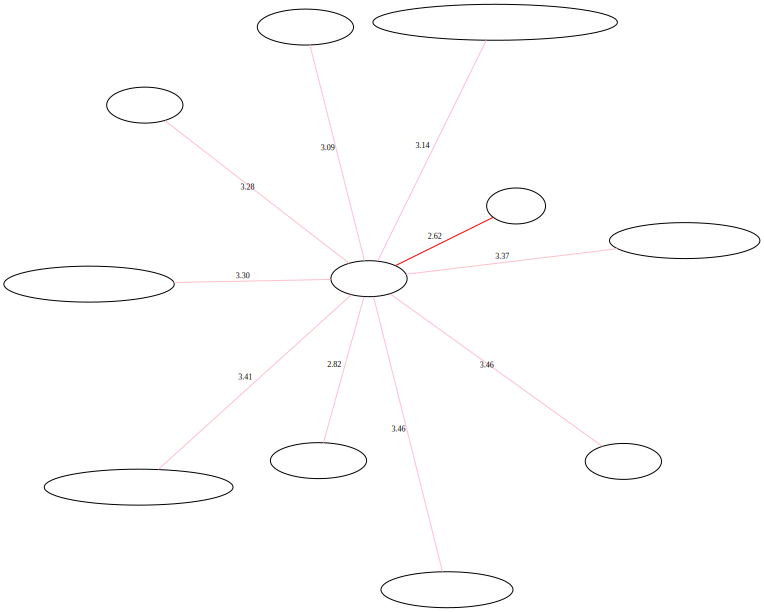

In [5]:
show_graph (dict_sort[0][0], w2v_model)

Show word list and graph...
ไม่ : ไม่รู้(2.14), ก็(2.45), คิดว่า(2.55), แต่(2.57), ได้(2.61), ครับ(2.64), ถึก(2.79), ขนาดนั้น(2.83), ไม่มาก(2.89), แล้วอยาก(2.92), 



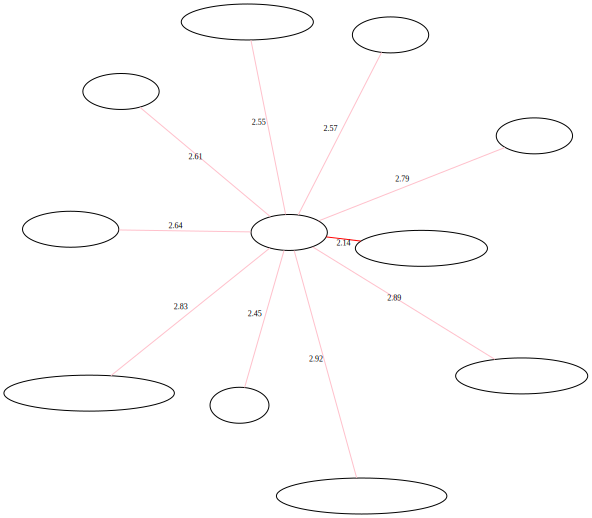

In [6]:
show_graph (dict_sort[1][0], w2v_model)

Show word list and graph...
ครับ : ผม(1.96), ก็(2.04), ถ้า(2.10), ผมยัง(2.23), คับ(2.33), ครับยัง(2.39), ครับว่า(2.39), ผมว่า(2.40), ซื้อมา(2.43), ของบ้าง(2.48), 



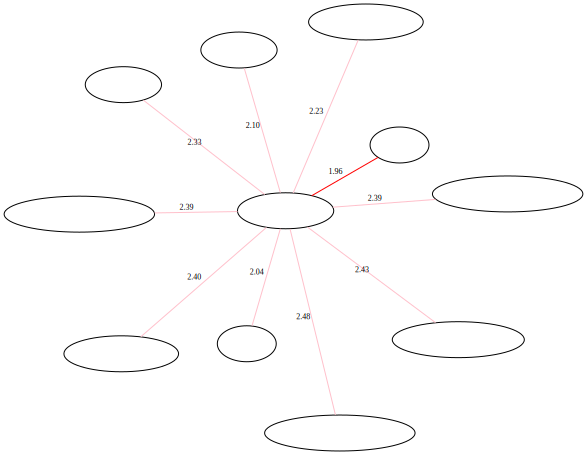

In [7]:
show_graph (dict_sort[2][0], w2v_model)

Show word list and graph...
ได้ : ก็(2.25), ผมยัง(2.58), ไม่(2.61), ครับ(2.81), ไต่(2.85), ซื้อมั้ย(2.99), ก็ดูดีดู(3.01), ไป(3.05), จะ(3.06), ต้อง(3.07), 



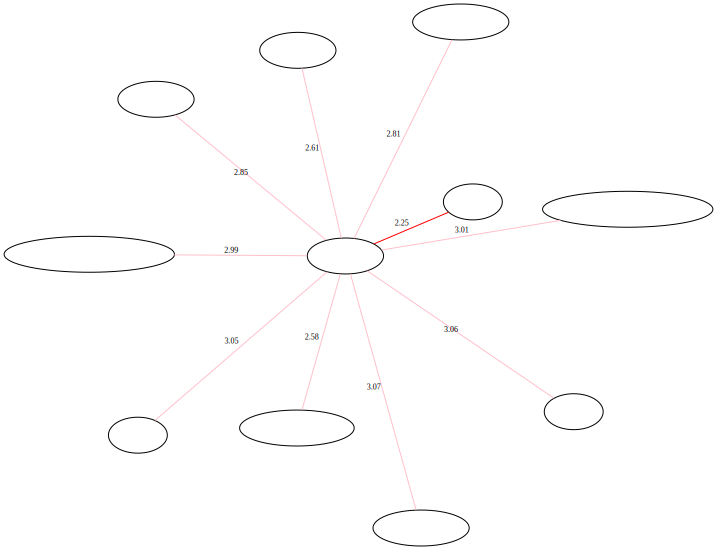

In [8]:
show_graph (dict_sort[3][0], w2v_model)

Show word list and graph...
ไป : ก็(2.33), แต่นอน(2.39), เมื่อยนิด(2.42), ซื้อมา(2.51), ไปช่าง(2.72), จอด(2.76), โมงลงรถ(2.80), กันชั่ว(2.82), เลยนะง่ายๆ(2.83), กระบะดันราง(2.86), 



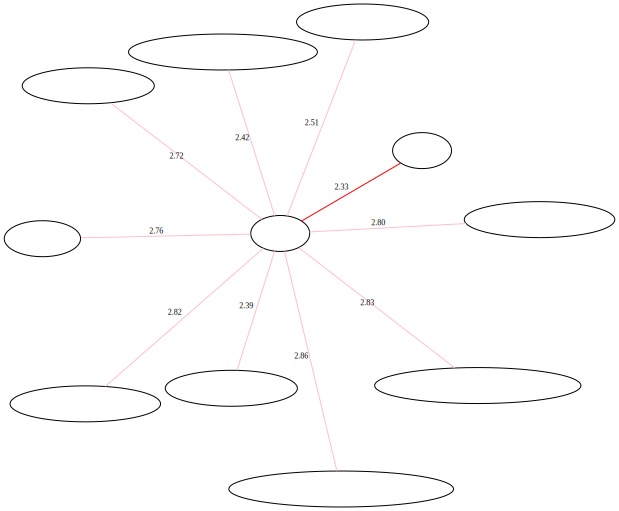

In [9]:
show_graph (dict_sort[4][0], w2v_model)

Show word list and graph...
จะ : ก็(2.48), หน่อยยอด(2.73), ก่อนอยู่(2.74), เวลา(2.76), ไม่รู้(2.81), คง(2.86), แต่(2.89), ครับดังนั้น(2.99), ก่อน(3.00), ถต่อ(3.01), 



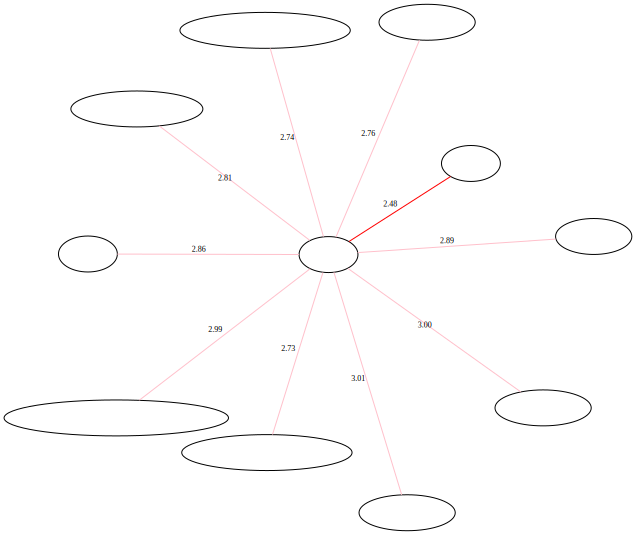

In [10]:
show_graph (dict_sort[5][0], w2v_model)

Show word list and graph...
ก็ : ครับ(2.04), ผมยัง(2.13), ได้(2.25), ไป(2.33), ไม่(2.45), จะ(2.48), เลย(2.53), ซื้อมา(2.54), แต่(2.61), ค่อย(2.66), 



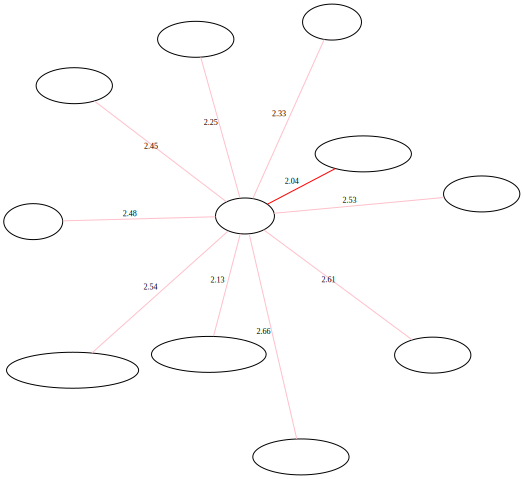

In [11]:
show_graph (dict_sort[6][0], w2v_model)

Show word list and graph...
การ : แผน(2.25), พการ(2.25), และ(2.37), จึง(2.37), การบริ(2.38), โภ(2.43), ผู้(2.47), ผูั(2.52), เพื่อ(2.52), ทั่ๆ(2.54), 



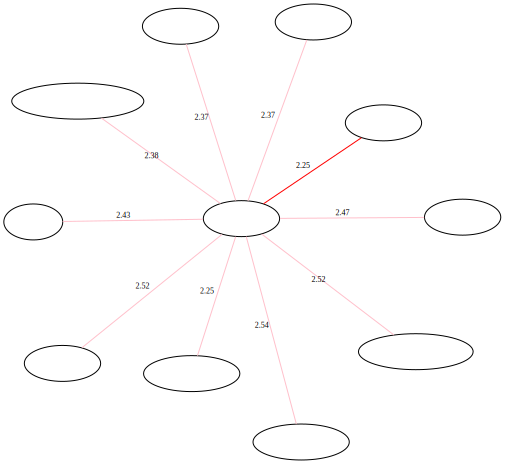

In [12]:
show_graph (dict_sort[7][0], w2v_model)

Show word list and graph...
แต่ : ไม่(2.57), ก็(2.61), แต่มัน(2.75), ขนาดรา(2.82), จุดด้อย(2.86), แต่ยัง(2.86), จะ(2.89), แต่ยาริส(2.90), หรอก(2.90), ครับ(2.93), 



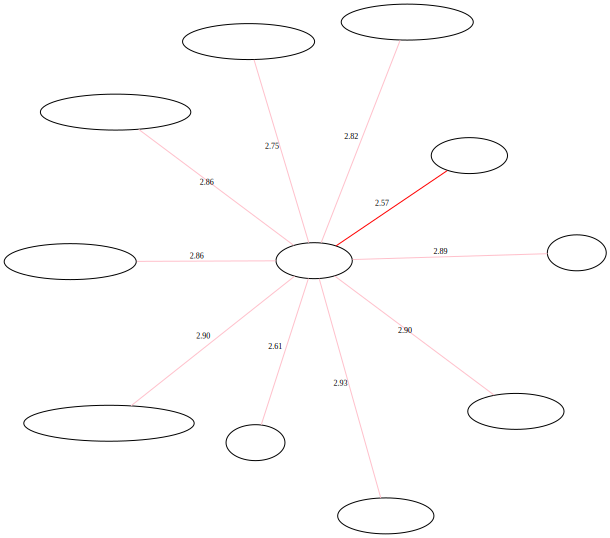

In [13]:
show_graph (dict_sort[8][0], w2v_model)

Show word list and graph...
ใน : ในมี(2.44), ในร(2.53), ในมีมา(2.61), ที่(2.62), คี(2.68), สามัค(2.70), จองอย่าง(2.71), ในมีนา(2.76), ในชม(2.76), ขณะนี้(2.83), 



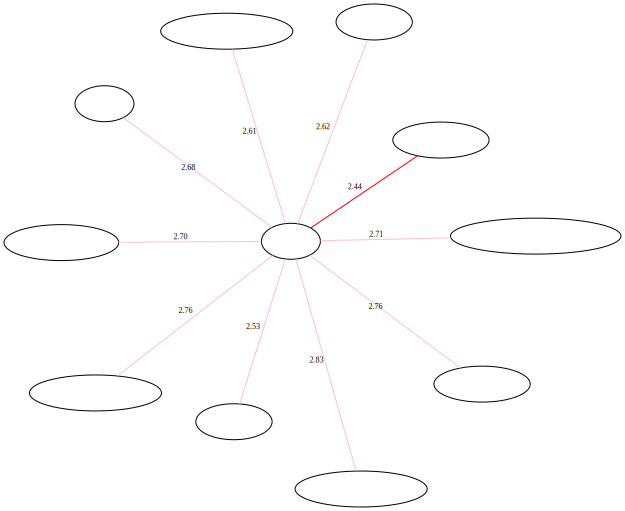

In [14]:
show_graph (dict_sort[9][0], w2v_model)